In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.stats import norm
import matplotlib.pyplot as plt
import time

In [ ]:
sizes = [1000, 10000, 100000, 1000000]

def generate(sizes):
  numbers = []
  for s in sizes:
    np.random.seed(42)
    numbers.append(np.random.uniform(size= s))

  return numbers

def samplestatistics(array,target_val):
  mean = np.mean(array)
  variance = np.var(array)
  std = np.std(array)
  skw = skew(array)
  kurt = kurtosis(array)
  p_value = 1 - norm.cdf(np.abs(mean - target_val)/std)
  return {'mean': mean, 'variance': variance, 'std': std, 'skew': skw, 'kurtosis': kurt, 'P-value': p_value}


def box_muller(data):
  parition = int(len(data)/2)
  u1 = np.array(data[:parition])
  u2 = np.array(data[parition:])

  # Box-Muller transform
  z0 = np.sqrt(-2.0 * np.log(u1)) * np.cos(2.0 * np.pi * u2)
  z1 = np.sqrt(-2.0 * np.log(u1)) * np.sin(2.0 * np.pi * u2)

  return np.concatenate([z0,z1])

numbers = generate(sizes)
gaussian_numbers = [box_muller(data) for data in numbers]

a)

In [ ]:
S_0 = 3900
K = 3900
T = 1
sigma = 25/100
r = 3/100
y = 1.30/100
mu_q = r - y - 0.5 * sigma**2
S_T = [S_0 * np.exp(mu_q * T + sigma * np.sqrt(T) * z_i) for z_i in gaussian_numbers]
log_S_T = [(np.log(S_0) + mu_q * T + sigma * np.sqrt(T) * z_i) for z_i in gaussian_numbers]

i.

In [ ]:
values = []
for i, size in enumerate(sizes):
  sample_mean = np.mean(S_T[i])
  sample_std = np.std(S_T[i])
  log_mean = np.mean(log_S_T[i])
  log_var = np.var(log_S_T[i])
  values.append([size, sample_mean, sample_std, log_mean, log_var])

df = pd.DataFrame(values, columns=['size', 'sample_mean', 'sample_std', 'log_mean', 'log_var'])
df

,size,sample_mean,sample_std,log_mean,log_var
0,1000,4020.888871,1048.296500,8.266831,0.064317
1,10000,3974.559265,1020.143413,8.255957,0.063292
2,100000,3964.197629,1008.569969,8.253731,0.062627
3,1000000,3966.782756,1007.147971,8.254494,0.062421


Population value for sample mean, $E^{\mathbf{Q}}[S_T] = E^{\mathbf{Q}}[S_0 \exp[\tilde{\mu}^{\mathbf{Q}} (T-t) + \sigma \sqrt{T-t} z_i ] ] = S_0 \exp[\tilde{\mu}^{\mathbf{Q}}(T-t) + \dfrac{\sigma^2}{2} (T-t)]$

Population value for log mean, $E^{\mathbf{Q}}[\ln{S_T}] = \ln{S_0} + \tilde{\mu}^{\mathbf{Q}} (T-t)$

where $\tilde{\mu}^{\mathbf{Q}} = r - y - \sigma^2 /2$


In [ ]:
population_mean = S_0 * np.exp(mu_q * T + 0.5 * sigma**2 * T)
population_log_mean = np.log(S_0) + mu_q * T

p_value = 1 - norm.cdf(np.abs(sample_mean - population_mean)/sample_std)
l_p_value = 1 - norm.cdf(np.abs(log_mean - population_log_mean)/np.sqrt(log_var))
print(f"P-value for sample mean: {p_value}")
print(f"P-value for log mean: {l_p_value}")

P-value for sample mean: 0.49996672628073724
P-value for log mean: 0.4999810642619542


Since the p-value > 0.05, we cannot reject that sample mean and log mean is same as their population equivalents at 5% level. Hence, the sample and log means do not differ from their population values.

ii.

Yes, there exists a transformation $z_i^{'} = \alpha + \beta z_i$. To make the sample mean match $<S_{T,i}/S_t>_{n}$ match $E^{\mathcal{Q}}[S_T/S_t]$, $\alpha = \dfrac{\sigma \sqrt{T-t}}{2} - \dfrac{\ln{<e^{\beta (\sigma\sqrt{T-t}) z_i}>_n}}{\sigma \sqrt{T-t}}$

To make the log variance $var[\ln(S_{T,i}/S_t)]_n$ match $var(\ln(S_T/S_t))$, $\beta = \dfrac{1}{\sqrt{var[z_i]_n}}$

In [ ]:
transformed_gaussian_numbers = []
for i, z_i in enumerate(gaussian_numbers):
  var = np.var(z_i)
  beta = 1/np.sqrt(var)
  exp_mod_z_i = np.exp(beta * sigma * np.sqrt(T) * z_i)
  alpha = 0.5 * sigma * np.sqrt(T) - np.log(np.mean(exp_mod_z_i))/(sigma * np.sqrt(T))

  transformed_gaussian_numbers.append(alpha + beta * z_i)

transformed_S_T = [S_0 * np.exp(mu_q * T + sigma * np.sqrt(T) * z_i) for z_i in transformed_gaussian_numbers]

b)

In [ ]:
C_T = []
for s in S_T:
  C_T.append(np.maximum(s - K, 0))

transformed_C_T = []
for s in transformed_S_T:
  transformed_C_T.append(np.maximum(s - K, 0))

C_t = []
for i in range(len(sizes)):
  C_t.append(np.exp(-r * T) * np.mean(C_T[i]))

transformed_C_t = []
for i in range(len(sizes)):
  transformed_C_t.append(np.exp(-r * T) * np.mean(transformed_C_T[i]))

print(C_t)
print(transformed_C_t)

[451.4858097482699, 419.7201096395503, 412.183051341964, 412.71882705539485]
[415.28820116857764, 413.0164886336926, 413.2919727519985, 413.00452579845694]


i.

Exact call price obtained in PS 1 = 418.442606. The sample estimates are close but seem biased downwards.

In [ ]:
true_value = 418.44206
for i, size in enumerate(sizes):
  print(f'size = {size}, sample C_t = {C_t[i]}, p_value = {1 - norm.cdf(np.abs(C_t[i] - true_value)/(np.exp(-r*T) * np.std(C_T[i])))}')

size = 1000, sample C_t = 451.4858097482699, p_value = 0.4818756381981347
size = 10000, sample C_t = 419.7201096395503, p_value = 0.4992590006517347
size = 100000, sample C_t = 412.183051341964, p_value = 0.49629456002800765
size = 1000000, sample C_t = 412.71882705539485, p_value = 0.49661036630991595


The simulated value estimators do not significantly differ from population expectation at 5% level.

ii.

Expectation under risk-neutral measure

In [ ]:
import numpy as np
from scipy.stats import norm
from scipy.integrate import quad

# Risk-neutral density function for log-normal distribution
def risk_neutral_density(ST):
    mu = r - y - 0.5 * sigma**2
    return (1 / (ST * sigma * np.sqrt(2 * np.pi * T))) * np.exp(-(np.log(ST / S_0) - mu * T)**2 / (2 * sigma**2 * T))

def integrand_payoff(ST):
    return np.maximum(ST - K, 0) * risk_neutral_density(ST)

def integrand_payoff_squared(ST):
    return np.maximum(ST - K, 0)**2 * risk_neutral_density(ST)

E_payoff, _ = quad(integrand_payoff, 0, 10000000)
E_payoff_squared, _ = quad(integrand_payoff_squared, 0, 10000000)

variance_payoff = E_payoff_squared - E_payoff**2

print("Expected Payoff:", E_payoff)
print("Expected Payoff Squared:", E_payoff_squared)
print("Variance of Payoff:", variance_payoff)
print("Standard deviation of Payoff:", np.sqrt(variance_payoff))

Expected Payoff: 425.6169389813699
Expected Payoff Squared: 662700.2136098753
Variance of Payoff: 481550.4348620041
Standard deviation of Payoff: 693.9383509087851


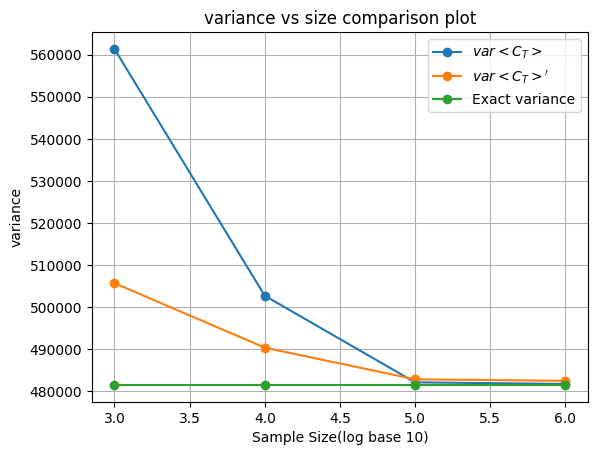

In [ ]:
variance_numerical = [np.var(C_T[i]) for i in range(0, len(sizes))]
transformed_variance_numerical = [np.var(transformed_C_T[i]) for i in range(0, len(sizes))]

plt.plot(np.log10(sizes), variance_numerical, marker='o', label=f'$var <C_T>$')
plt.plot(np.log10(sizes), transformed_variance_numerical,  marker='o', label=f"$var <C_T>'$")
plt.plot(np.log10(sizes), [variance_payoff] * len(sizes), marker='o', label='Exact variance')
plt.xlabel('Sample Size(log base 10)')
plt.ylabel('variance')
plt.title("variance vs size comparison plot")
plt.legend()
plt.grid()
plt.show()

The estimator variance is higher than exact variance of $[S_T - 3900]^+$ for small sample size and then reduces and converges to the exact variance for higher sample size.

[23.692780096831818, 7.090364252857316, 2.195828542257579, 0.6941004564420994]
[22.488061974345204, 7.0028648797727655, 2.1974697842768536, 0.6946328848734488]


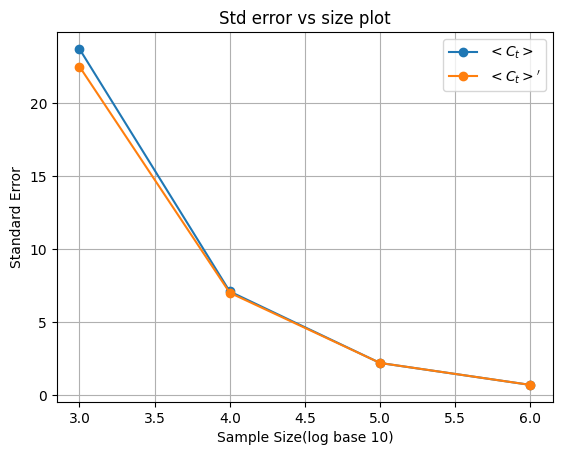

In [ ]:
std_errors = [np.std(C_T[i])/np.sqrt(sizes[i]) for i in range(0, len(sizes))]
transformed_std_errors = [np.std(transformed_C_T[i])/np.sqrt(sizes[i]) for i in range(0, len(sizes))]
print(std_errors)
print(transformed_std_errors)

plt.plot(np.log10(sizes), std_errors, marker='o', label=f'$<C_t>$')
plt.plot(np.log10(sizes), transformed_std_errors,  marker='o', label=f"$<C_t>'$")
plt.xlabel('Sample Size(log base 10)')
plt.ylabel('Standard Error')
plt.title("Std error vs size plot")
plt.legend()
plt.grid()
plt.show()

CLT standard errors seem to describe the convergence properties of $<C_t>$ and $<C_t>'$ well. The standard errors converge to a small value for large sample size. Binned CLT estimator may also explain the convergence properties of $<C_t>$.

iii.

Moment matching sequence ${z'_i}$ seems to be better than the bare bones method since it has lower standard errors of the call price estimator even for low sample sizes.

c)

Antithetic standard errors =  [12.425017449295161, 3.927499602997929, 1.2265858928876607, 0.3874953484176417]
Standard error ratios = [0.5244220981461195, 0.5539207102674877, 0.5585982098705126, 0.558269836622656]


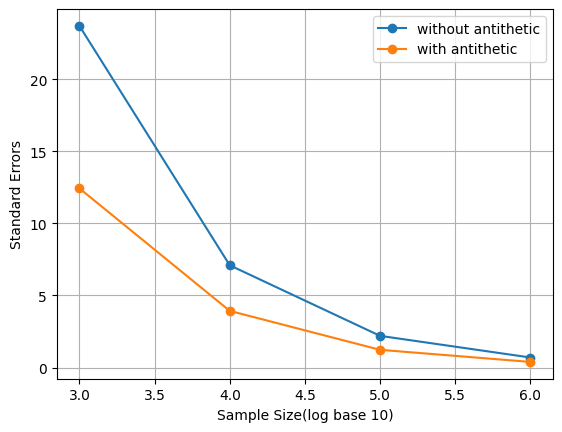

In [ ]:
S_T_a = [S_0 * np.exp(mu_q * T - sigma * np.sqrt(T) * z_i) for z_i in gaussian_numbers]
C_T_a = []
for i in range(len(sizes)):
  C_T_a.append(0.5 * (np.maximum(S_T[i]-K, 0) + np.maximum(S_T_a[i]-K, 0)))

C_t_a = []
for i in range(len(sizes)):
  C_t_a.append(np.exp(-r * T) * np.mean(C_T_a[i]))

std_errors_a = [np.std(C_T_a[i])/np.sqrt(sizes[i]) for i in range(0, len(sizes))]
print("Antithetic standard errors = ", std_errors_a)

std_errors_ratios = [y/x for x,y in zip(std_errors, std_errors_a)]
print(f"Standard error ratios = {std_errors_ratios}")

plt.plot(np.log10(sizes), std_errors, marker='o', label=f'without antithetic')
plt.plot(np.log10(sizes), std_errors_a,  marker='o', label=f'with antithetic')
plt.xlabel('Sample Size(log base 10)')
plt.ylabel('Standard Errors')
plt.grid()
plt.legend()
plt.show()

Standard errors for antithetic case seem 55.8% better.

In [ ]:
rho = 2 * (0.558**2) - 1
rho

-0.37727199999999983

Implied correlation is -0.377.

ii.

In [ ]:
efficiency_ratio = 1/(2 * (0.558**2))
print(f"Efficiency ratio = {efficiency_ratio}")

Efficiency ratio = 1.6058375406276892


iii.

In [ ]:
def measure_time(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Execution time of {func.__name__}: {execution_time:.6f} seconds")
        return result
    return wrapper

@measure_time
def BBMC(sizes):
  numbers = generate(sizes)
  gaussian_numbers = [box_muller(data) for data in numbers]
  S_T = [S_0 * np.exp(mu_q * T + sigma * np.sqrt(T) * z_i) for z_i in gaussian_numbers]

  C_T = []
  for s in S_T:
    C_T.append(np.maximum(s - K, 0))
  C_t = []
  for i in range(len(sizes)):
    C_t.append(np.exp(-r * T) * np.mean(C_T[i]))

  std_errors = [np.std(C_T[i])/np.sqrt(sizes[i]) for i in range(0, len(sizes))]

  return C_t, std_errors

@measure_time
def antithetic_MC(sizes):
    numbers = generate(sizes)
    gaussian_numbers = [box_muller(data) for data in numbers]
    S_T = [S_0 * np.exp(mu_q * T + sigma * np.sqrt(T) * z_i) for z_i in gaussian_numbers]

    C_T = []
    for s in S_T:
      C_T.append(np.maximum(s - K, 0))
    C_t = []
    for i in range(len(sizes)):
      C_t.append(np.exp(-r * T) * np.mean(C_T[i]))

    S_T_a = [S_0 * np.exp(mu_q * T - sigma * np.sqrt(T) * z_i) for z_i in gaussian_numbers]

    C_T_a = []
    for i in range(len(sizes)):
      C_T_a.append(0.5 * (np.maximum(S_T[i]-K, 0) + np.maximum(S_T_a[i]-K, 0)))

    C_t_a = []
    for i in range(len(sizes)):
      C_t_a.append(np.exp(-r * T) * np.mean(C_T_a[i]))


    std_errors_a = [np.std(C_T_a[i])/np.sqrt(sizes[i]) for i in range(0, len(sizes))]

    return C_t_a, std_errors_a

_, __ = BBMC(sizes)
_, __ = antithetic_MC(sizes)

Execution time of BBMC: 0.081356 seconds
Execution time of antithetic_MC: 0.111310 seconds


In [ ]:
new_efficieny_metric = 0.081356/(0.111310 * (0.558**2))
print(f"New efficiency metric = {new_efficieny_metric}")

New efficiency metric = 2.3473994960974984


Behaviour is different from theoretical considerations. The time taken for antithetic MC is less than double of bare bones MC. Hence, the efficieny metric is also higher = 2.35 compared to 1.60 earlier.

e)

$\rho_{y, LR} = -\dfrac{\sqrt{T}}{\sigma} e^{-rT}<z_i C_{T,i}> = -\dfrac{\sqrt{T}}{\sigma} \dfrac{e^{-rT}}{n} \sum_{i=1}^{n} z_i (S_{T,i} - K)^+$

$<C_0>_{S_0 + ϵ} = e^{-rt}<\dfrac{q'(S_{T,i}|S_0 + ϵ)}{q(S_{T,i}|S_0)} C_{T,i}>_{S_0 + \epsilon}$

$\dfrac{q'(S_{T,i}|S_0 + ϵ)}{q(S_{T,i}|S_0)} = \dfrac{q(S_{T,i}|S_0) + \epsilon~ \partial_{S_0}{q(S_{T,i}|S_0)}}{q(S_{T,i}|S_0)}$

$\Delta_{S,LR} = \lim_{\epsilon \to 0} {\dfrac{<C_0>_{S_0 + ϵ} - <C_0>_{S_0}}{<C_0>_{S_0}}} = e^{-rt} <\dfrac{\partial_{S_0}{q(S_{T,i}|S_0)}} {q(S_{T,i}|S_0)} C_{T,i}> = e^{-rt} <\partial_{S_0}{\ln q(S_{T,i}|S_0)}~ C_{T,i}>$

$ = e^{-rT} <\dfrac{\ln(S_{T,i}/S_0) - \tilde{\mu}^{\mathcal{Q}} T}{\sigma^2 T S_0} ~ C_{T,i}> = \dfrac{1}{\sigma S_0 \sqrt{T}} e^{-rT} < z_i C_{T,i}> = \dfrac{e^{-rT}}{\sigma S_0\sqrt{T}}\dfrac{\sum_{i=1}^{n}{z_i (S_{T,i} - K)^+}}{n}$


$\dfrac{\rho_{y,LR}}{\Delta_{S,LR}} = -S_0 T$


The $\rho_{y,LR}$ and $\Delta_{S,LR}$ are related. They have similar structure and are just multiplied by different constant. Their variation with sample size $n$ is inversely correlated and can be seen in the plot.

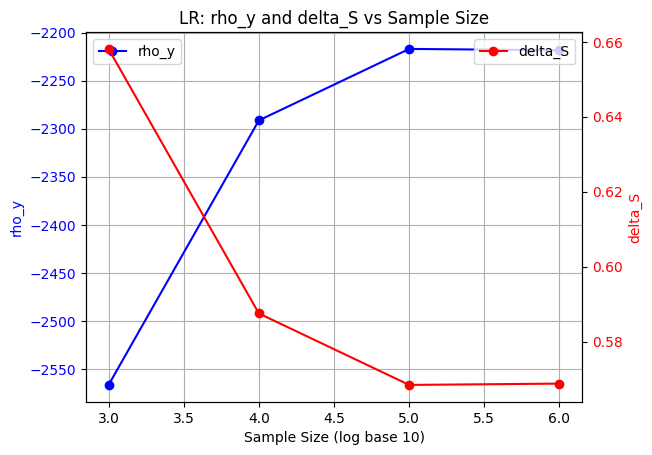

In [ ]:
rho_y = []
for i in range(len(sizes)):
  rho_y.append(-np.sqrt(T)/sigma * np.exp(-r*T) * np.mean([x * y for x,y in zip(gaussian_numbers[i], C_T[i])]))

delta_S = []
for i in range(len(sizes)):
  delta_S.append(np.exp(-r*T)/(sigma * S_0 * np.sqrt(T)) * np.mean([x * y for x,y in zip(gaussian_numbers[i], C_T[i])]))

fig, ax1 = plt.subplots()

# Plot rho_y on the primary y-axis
ax1.plot(np.log10(sizes), rho_y, marker='o', label='rho_y', color='b')
ax1.set_xlabel('Sample Size (log base 10)')
ax1.set_ylabel('rho_y', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True)

# Create a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(np.log10(sizes), delta_S, marker='o', label='delta_S', color='r')
ax2.set_ylabel('delta_S', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add a title
plt.title("LR: rho_y and delta_S vs Sample Size")

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

d)

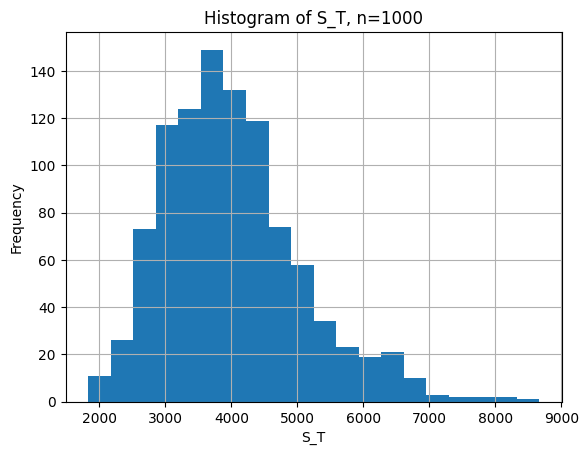

In [ ]:
epsilon_list = [0.1, 0.01, 0.001]
gaussian_numbers_0 = np.array(gaussian_numbers[0])
lower_bound = np.exp(-2 * sigma * np.sqrt(T)) * K
upper_bound = np.exp(2 * sigma * np.sqrt(T)) * K
exp_factors = np.exp(mu_q * T + sigma * np.sqrt(T) * gaussian_numbers_0)

S_T = [S_0 * np.exp(mu_q * T + sigma * np.sqrt(T) * z_i) for z_i in gaussian_numbers_0]
plt.hist(S_T, bins=20)
plt.xlabel('S_T')
plt.ylabel('Frequency')
plt.title('Histogram of S_T, n=1000')
plt.grid()
plt.show()

i.

In [ ]:
def black_scholes_delta(S, K, T, r, sigma, y, option_type='call'):
    d1 = (np.log(S / K) + (r - y + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if option_type == 'call':
        delta = np.exp(-y * T) * norm.cdf(d1)
    elif option_type == 'put':
        delta = np.exp(-y * T) * (norm.cdf(d1) - 1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")
    return delta

def black_scholes_gamma(S, K, T, r, sigma, y):
    d1 = (np.log(S / K) + (r - y + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    return gamma

def delta_plus(S_0_values, epsilon):
  delta_plus_list = []
  for s in S_0_values:
    S_T_plus = s * (1 + epsilon) * exp_factors
    C_t_plus = np.exp(-r * T) * np.mean(np.maximum(S_T_plus-K, 0))

    S_T_original = s * exp_factors
    C_t_original = np.exp(-r * T) * np.mean(np.maximum(S_T_original-K, 0))

    delta_plus_list.append((C_t_plus - C_t_original)/(epsilon * s))
  return delta_plus_list

def delta_minus(S_0_values, epsilon):
  delta_minus_list = []
  for s in S_0_values:
    S_T_minus = s * (1 - epsilon) * exp_factors
    C_t_minus = np.exp(-r * T) * np.mean(np.maximum(S_T_minus-K, 0))

    S_T_original = s * exp_factors
    C_t_original = np.exp(-r * T) * np.mean(np.maximum(S_T_original-K, 0))

    delta_minus_list.append((-C_t_minus + C_t_original)/(epsilon * s))
  return delta_minus_list

def delta_c(delta_plus_list, delta_minus_list, epsilon):
  return [0.5*(x + y) for x,y in zip(delta_plus_list, delta_minus_list)]

def gamma(delta_plus_list, delta_minus_list, S_0_values, epsilon):
  return [(x - y)/(epsilon * s) for x,y,s in zip(delta_plus_list, delta_minus_list, S_0_values)]

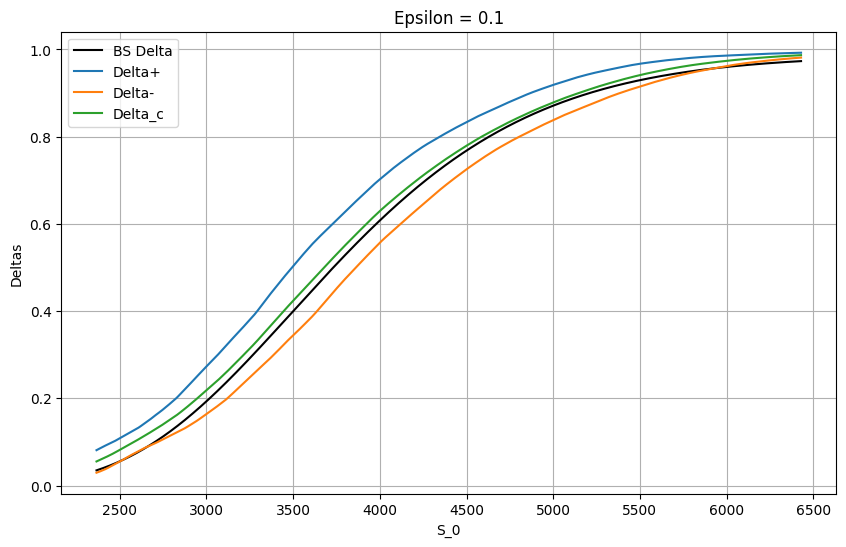

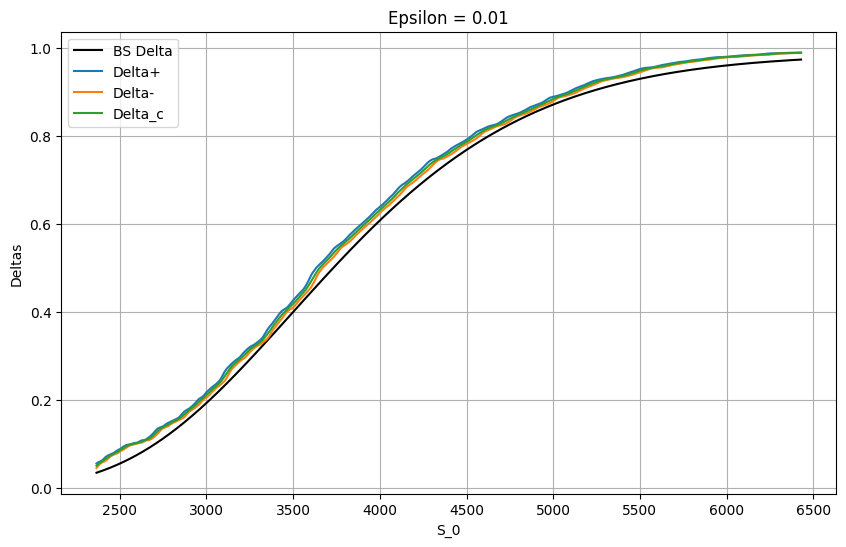

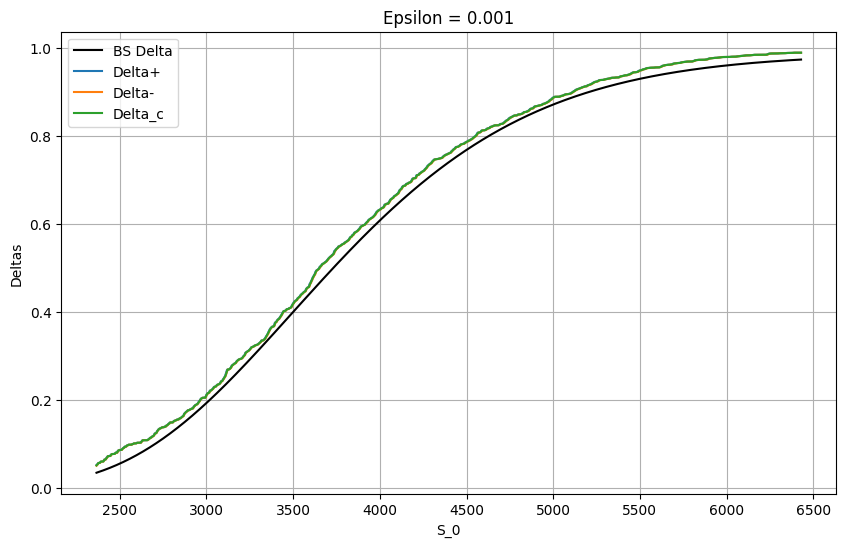

In [ ]:
S_0_values = np.arange(lower_bound, upper_bound + 0.05, 0.05)

def work_for_delta(S_0_values, epsilon_list):
  bs_delta = [black_scholes_delta(S, K, T, r, sigma, y) for S in S_0_values]
  gammas_dict = {}


  for epsilon in epsilon_list:
    delta_plus_list = delta_plus(S_0_values, epsilon)
    delta_minus_list = delta_minus(S_0_values, epsilon)
    delta_c_list = delta_c(delta_plus_list, delta_minus_list, epsilon)
    gamma_list = gamma(delta_plus_list, delta_minus_list, S_0_values, epsilon)
    gammas_dict[epsilon] = gamma_list

    plt.figure(figsize=(10, 6))
    plt.plot(S_0_values, bs_delta, label='BS Delta', color = 'black')
    plt.plot(S_0_values, delta_plus_list, label='Delta+')
    plt.plot(S_0_values, delta_minus_list, label='Delta-')
    plt.plot(S_0_values, delta_c_list, label='Delta_c')

    plt.title(f'Epsilon = {epsilon}')
    plt.xlabel('S_0')
    plt.ylabel('Deltas')
    plt.legend()
    plt.grid()
    plt.show()
  return gammas_dict

gammas_dict = work_for_delta(S_0_values, epsilon_list)

The finite difference deltas curve is smooth for epsilon = 0.1 but it gets noisy as we make the bumps smaller. The discretization effects are visible clearly for $\epsilon$ < 0.1. For large bump = 0.1, bias in $\Delta_+$ and $\Delta_-$ is apparent.

ii.

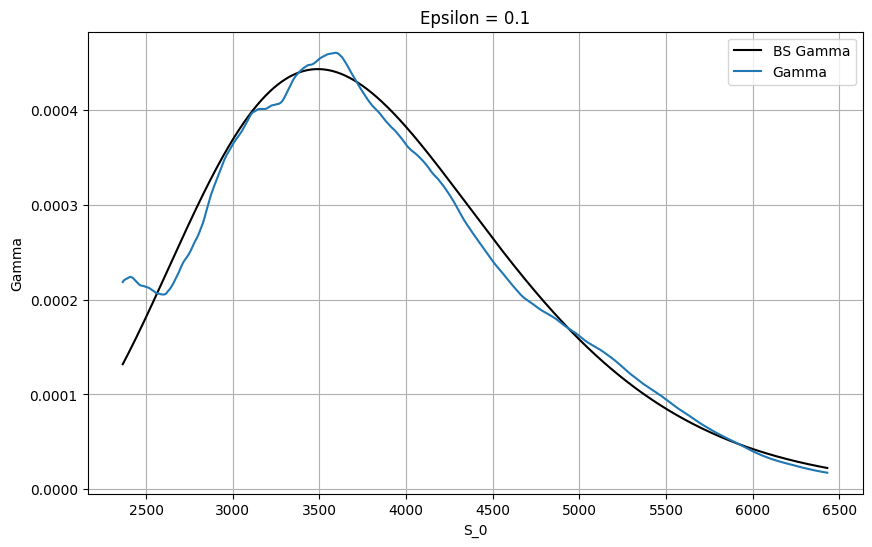

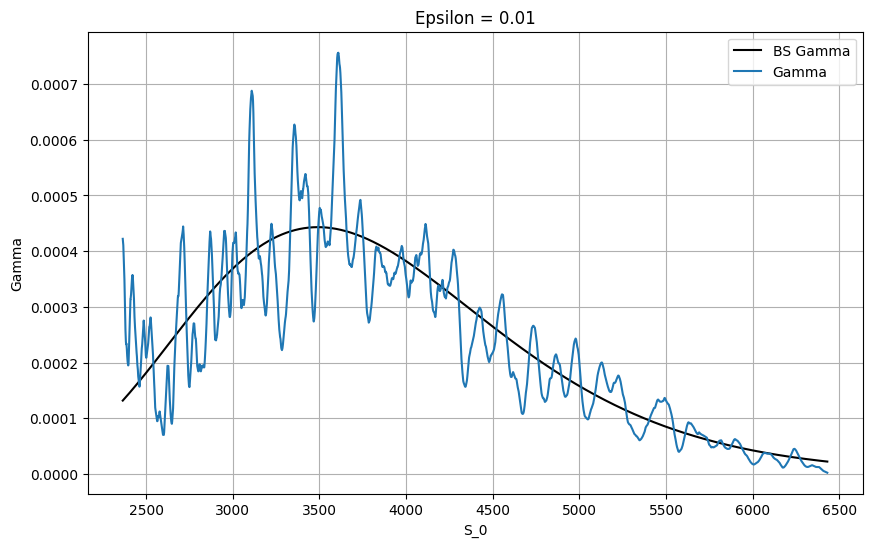

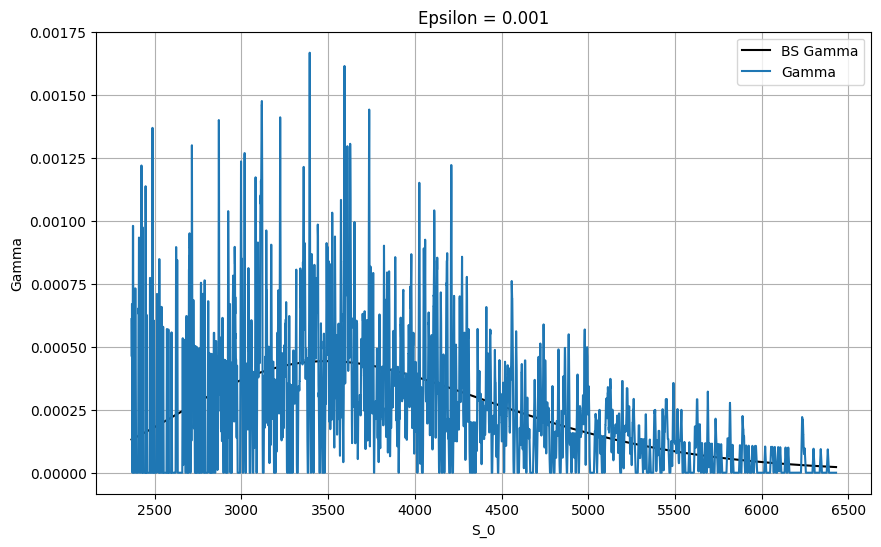

In [ ]:
bs_gamma = [black_scholes_gamma(S, K, T, r, sigma, y) for S in S_0_values]
for epsilon in epsilon_list:
  plt.figure(figsize=(10, 6))
  plt.plot(S_0_values, bs_gamma, label='BS Gamma', color = 'black')
  plt.plot(S_0_values, gammas_dict[epsilon], label='Gamma')

  plt.title(f'Epsilon = {epsilon}')

  plt.xlabel('S_0')
  plt.ylabel('Gamma')
  plt.legend()
  plt.grid()
  plt.show()

Discretization effects are quite prominent for gamma. The finite difference gamma curve has bias but is relatively smooth for large bump. As the epsilon is reduced below 0.1, the delta function like shocks due to double derivative of kinks become apparent. For $\epsilon = 0.001$, the discretization error is severe.